# Data preparation

In [2]:
library(DESeq2)
library(ggplot2)
library(pheatmap)
library(dplyr)
library(tidyverse)
library(reshape2)
library(ggrepel)
library(data.table)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, saveRDS, setdiff, table,
    tapply, union, unique, unsplit, which.max, which.min



Attaching package: 'S4Vectors'


The following object is masked from 'package:utils':

    findMatches


The following objects are masked from 'package:base':

    I, expand.grid, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb



In [3]:
library(RColorBrewer)

## Set a color-blind friendly palette
heat_colors <- rev(brewer.pal(11, "RdBu"))
heat_colors

[1] "#053061" "#2166AC" "#4393C3" "#92C5DE" "#D1E5F0" "#F7F7F7" "#FDDBC7"
 [8] "#F4A582" "#D6604D" "#B2182B" "#67001F"

In [4]:
# load dds object
dds <- readRDS("data/dds.rds")
dds

class: DESeqDataSet 
dim: 6134 6 
metadata(1): version
assays(4): counts mu H cooks
rownames(6134): YDL248W YDL245C ... Q0158 Q0160
rowData names(22): baseMean baseVar ... deviance maxCooks
colnames(6): WT_C_1 WT_C_2 ... WT_E_2 WT_E_3
colData names(2): condition sizeFactor

# Visualization of Differential Expression Genes

In this section, we will generate some key data tables and use a different visualization techniques to explore our results, including:
- Table of results for all genes
- Table of results for significant genes (adjusted p-value < 0.05)
- Scatterplot of normalized expression of top 20 most significant genes
- Heatmap of all significant genes
- Volcano plot of results for all genes

In [5]:
# read results from file
res_tbl <- read.csv("data/E_vs_C_all_genes.csv", row.names = 1)
res_tbl <- res_tbl %>%
  data.frame() %>%
  rownames_to_column(var = "gene") %>%
  as_tibble() %>%
  arrange(padj)

head(res_tbl)

gene,baseMean,log2FoldChange,lfcSE,pvalue,padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
YMR174C,4392.762,5.504908,0.1840782,1.088750e-197,6.664236e-194
YBR072W,30053.806,6.516708,0.2295216,4.279000e-178,1.309588e-174
YBR117C,7641.370,7.430477,0.2699041,5.023902e-168,1.025043e-164
YGR256W,7219.422,6.772904,0.2830174,1.177464e-127,1.801814e-124
YMR175W,8530.858,7.518518,0.3353447,1.299220e-112,1.590506e-109
YGL121C,4733.685,4.326446,0.1952246,6.559172e-110,6.691449e-107


## Table of results for significant genes

Filter our table to extract only the significant genes using a p-adjusted threshold of `0.05`:

The `arrange` function sorts the rows of the filtered data frame (sig_res) in ascending order based on the padj column. Rows with smaller padj values appear first.

In [6]:
# Set thresholds
padj_cutoff <- 0.05

# records before
nrow_before <- nrow(res_tbl)

# Subset the significant results
sig_res <- dplyr::filter(res_tbl, padj < padj_cutoff) %>%
  dplyr::arrange(padj)

# records after
nrow_after <- nrow(sig_res)

# print the number of significant results
cat("Total records:", nrow_before, "\n")
cat("Number of significant results:", nrow_after, "\n")
cat("Percentage of significant results:", nrow_after / nrow_before * 100, "%\n")

Total records: 6134 
Number of significant results: 3221 
Percentage of significant results: 52.5106 %


In [7]:
# Write significant results to the "data/" directory
condition <- factor(c("C", "C", "C", "E", "E", "E"))

save_path <- file.path(
  "data",
  paste0(levels(condition)[2], "_vs_", levels(condition)[1],
         "_signif_genes.csv")
)
write.csv(res_tbl,
          file = save_path,
          quote = FALSE,
          row.names = FALSE)

## Fold change

We may also be interested in determining the total number of significantly upregulated or downregulated genes above a certain fold change threshold (for example log2 fold change (in absolute value) >0.58, which corresponds to a ~50% increase (or ~30% decrease) in gene expression.

The main reasons for calculating **log fold change** in DEG analysis are:

1. **Normalization of Data**: Log transformation helps normalize the data, especially when there are large differences in gene expression. Fold change values can vary dramatically between genes (e.g., a gene with fold change 2 might be considered significant, but 10,000 fold change would be a huge outlier).
   
2. **Symmetry**: Log fold change (typically log2) ensures that the scale is symmetric. A 2-fold upregulation (FC = 2) and a 2-fold downregulation (FC = 0.5) will both result in a log fold change of +1 and -1, respectively. This symmetry makes it easier to interpret upregulations and downregulations.
   
3. **Handling Small and Large Changes**: The log scale compresses the range of values, which allows both small and large changes to be analyzed in a comparable manner. For example, a fold change of 10,000 becomes a manageable value when transformed into a log scale (log2(10000) ≈ 13.29).
   
4. **Statistical Analysis**: Log-transformed data are more likely to conform to the assumptions of statistical tests (e.g., normality and variance homogeneity), making the results more reliable.

In summary, **log fold change** is used to make gene expression changes more interpretable, stable, and statistically robust, particularly when working with wide-ranging data across different genes or conditions.

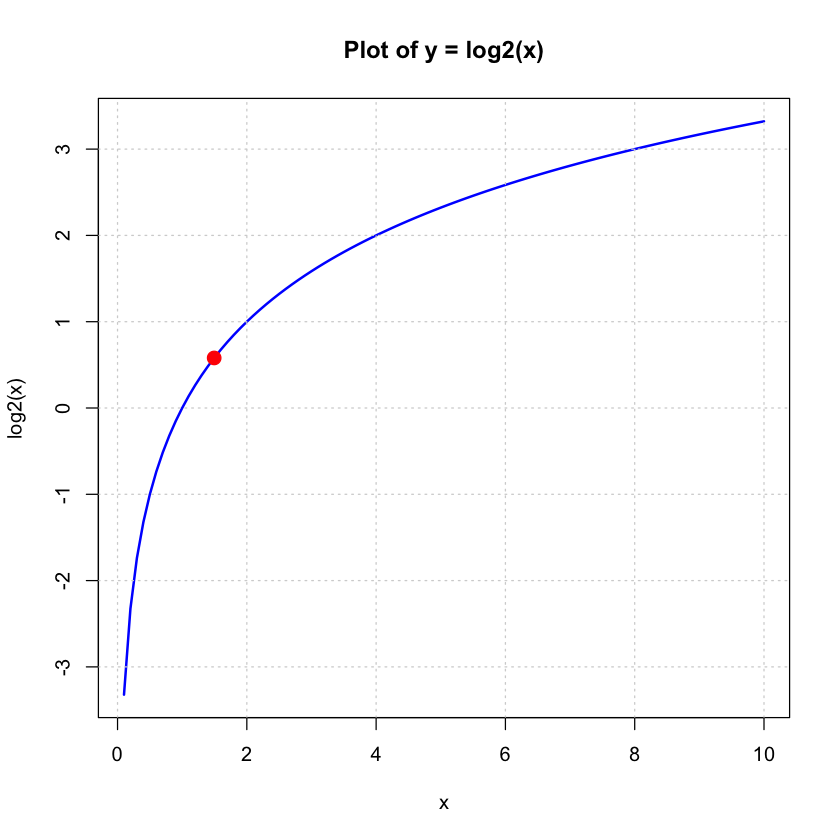

In [8]:
# Define a range of x values
x <- seq(0.1, 10, by = 0.1)

# Calculate the log2 of x
y <- log2(x)

# Plot the graph
plot(x, y, type = "l", col = "blue", lwd = 2, 
     xlab = "x", ylab = "log2(x)", main = "Plot of y = log2(x)")
grid()

# Calculate the x value where y = 0.58
x_dot <- 2^0.58
y_dot <- 0.58

# Add a red dot at the point where y = 0.58
points(x_dot, y_dot, col = "red", pch = 19, cex = 1.5)


In [9]:
# Set thresholds
log2fc_cutoff <- 0.58

# Count significantly up/down genes above threshold
n_sig_up <- dplyr::filter(sig_res, log2FoldChange >= log2fc_cutoff) %>%
  nrow()
n_sig_dn <- dplyr::filter(sig_res, log2FoldChange <= -log2fc_cutoff) %>%
  nrow()

# print the number of significantly up/down genes
cat("Number of significantly up-regulated genes:", n_sig_up, "\n")
cat("Number of significantly down-regulated genes:", n_sig_dn, "\n")  

Number of significantly up-regulated genes: 1394 
Number of significantly down-regulated genes: 1430 


## Scatterplot of top 20 most significant genes

In [10]:
## Extract normalized counts from dds object
normalized_counts <- counts(dds, normalized = TRUE)

## Extract top 20 DEG from resLFC (make sure to order by padj)
top20_sig_genes <- sig_res %>%
  dplyr::arrange(padj) %>%
  dplyr::pull(gene) %>%
  head(n = 20)

## Extract matching normalized count values from matrix
cond_matched_counts <- rownames(normalized_counts) %in% top20_sig_genes
top20_sig_counts <- normalized_counts[cond_matched_counts, ]
top20_sig_counts

,WT_C_1,WT_C_2,WT_C_3,WT_E_1,WT_E_2,WT_E_3
YDL169C,187.810691,186.901038,195.18255,1575.995,2216.0085,1692.709
YDL130W-A,1177.471815,1277.355505,1327.24131,7081.159,6648.9062,6498.792
YDL085W,38.236907,26.189954,64.71842,1448.870,2405.3733,2475.942
YOR120W,1532.850128,1347.592201,1158.76796,10971.559,13998.0217,11680.934
YGL156W,659.024340,644.034788,457.13807,6509.545,8304.7471,6333.433
YGL121C,459.967500,436.896058,437.61981,10510.842,8580.4271,7976.356
YGR256W,120.333796,101.188460,164.36425,10850.745,15330.6214,16749.281
YPL223C,55.106131,54.760814,82.18212,7840.305,6804.8018,12299.698
YML042W,157.446088,209.519635,212.64625,1916.800,2484.6422,2544.397
YMR090W,1122.365684,1455.923376,1626.17879,14340.834,15830.8967,14574.719


In [11]:
## Convert wide matrix to long data frame for ggplot2
top20_sig_df <- data.frame(top20_sig_counts)
top20_sig_df$gene <- rownames(top20_sig_counts)
top20_sig_df

,WT_C_1,WT_C_2,WT_C_3,WT_E_1,WT_E_2,WT_E_3,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
YDL169C,187.810691,186.901038,195.18255,1575.995,2216.0085,1692.709,YDL169C
YDL130W-A,1177.471815,1277.355505,1327.24131,7081.159,6648.9062,6498.792,YDL130W-A
YDL085W,38.236907,26.189954,64.71842,1448.870,2405.3733,2475.942,YDL085W
YOR120W,1532.850128,1347.592201,1158.76796,10971.559,13998.0217,11680.934,YOR120W
YGL156W,659.024340,644.034788,457.13807,6509.545,8304.7471,6333.433,YGL156W
YGL121C,459.967500,436.896058,437.61981,10510.842,8580.4271,7976.356,YGL121C
YGR256W,120.333796,101.188460,164.36425,10850.745,15330.6214,16749.281,YGR256W
YPL223C,55.106131,54.760814,82.18212,7840.305,6804.8018,12299.698,YPL223C
YML042W,157.446088,209.519635,212.64625,1916.800,2484.6422,2544.397,YML042W


- `id.vars = c("gene")`: Specifies that the column `gene` should remain as is (it’s the identifier variable and will not be melted).
- `variable.name = "sample_id"`: Renames the column containing the variable names (e.g., sample columns in the wide format) to `sample_id`.

In [12]:
top20_sig_df <- melt(setDT(top20_sig_df),
                     id.vars = c("gene"),
                     variable.name = "sample_id") %>%
  data.frame()
head(top20_sig_df)

,gene,sample_id,value
,<chr>,<fct>,<dbl>
1,YDL169C,WT_C_1,187.81069
2,YDL130W-A,WT_C_1,1177.47182
3,YDL085W,WT_C_1,38.23691
4,YOR120W,WT_C_1,1532.85013
5,YGL156W,WT_C_1,659.02434
6,YGL121C,WT_C_1,459.96750


In [13]:
head(counts(dds))

,WT_C_1,WT_C_2,WT_C_3,WT_E_1,WT_E_2,WT_E_3
YDL248W,248,224,319,523,485,586
YDL245C,22,6,10,60,34,28
YDL244W,14,17,8,58,112,55
YDL243C,204,189,185,503,563,344
YDL242W,18,23,24,32,46,38
YDL241W,152,106,125,22,13,29


In [14]:
colData(dds)

DataFrame with 6 rows and 2 columns
       condition sizeFactor
        <factor>  <numeric>
WT_C_1         C   0.889193
WT_C_2         C   0.840017
WT_C_3         C   0.973448
WT_E_1         E   1.109140
WT_E_2         E   1.135375
WT_E_3         E   1.124824

In [15]:
rownames(colData(dds))

[1] "WT_C_1" "WT_C_2" "WT_C_3" "WT_E_1" "WT_E_2" "WT_E_3"

In [16]:
## Create the sample_id column
colData(dds)$sample_id <- rownames(colData(dds))

## Join counts data frame with metadata
top20_sig_df <- merge(
  top20_sig_df,
  as.data.frame(colData(dds)),
  by = "sample_id",
  all.x = TRUE
)
head(top20_sig_df)

,sample_id,gene,value,condition,sizeFactor
,<fct>,<chr>,<dbl>,<fct>,<dbl>
1,WT_C_1,YDL169C,187.81069,C,0.8891933
2,WT_C_1,YDL130W-A,1177.47182,C,0.8891933
3,WT_C_1,YDL085W,38.23691,C,0.8891933
4,WT_C_1,YOR120W,1532.85013,C,0.8891933
5,WT_C_1,YGL156W,659.02434,C,0.8891933
6,WT_C_1,YGL121C,459.96750,C,0.8891933


**Aesthetic** mappings describe how variables in the data are mapped
 to visual properties (aesthetics) of geoms. Aesthetic mappings can
 be set in ‘ggplot()’ and in individual layers.

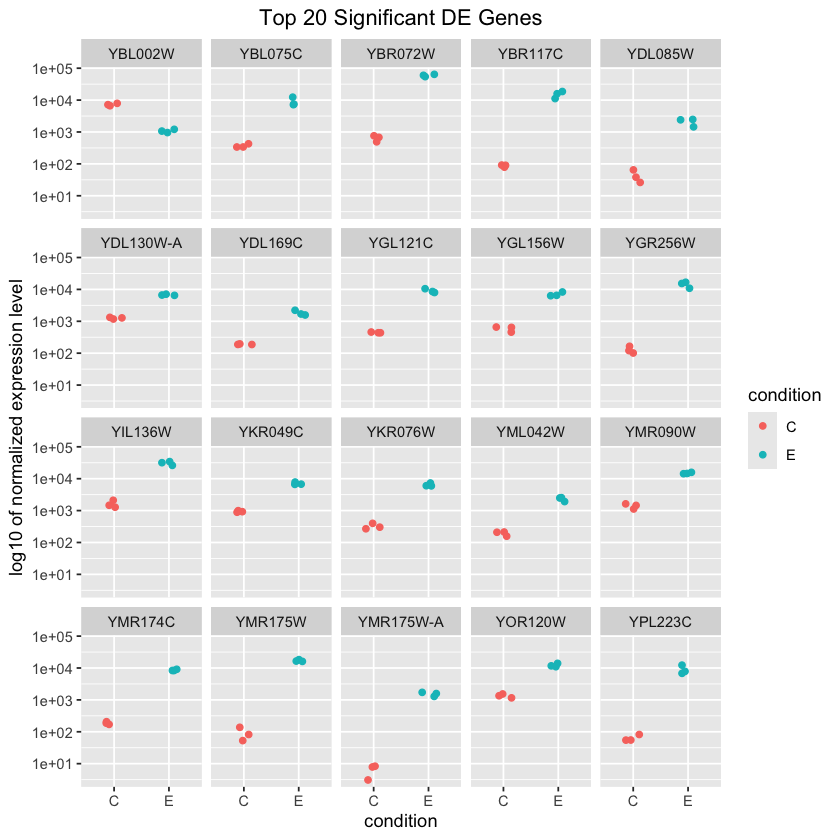

In [17]:
## Generate plot
# Initializes the plot with the dataset top20_sig_df and specifies the aesthetics (the mapping of data to plot elements).
ggplot(top20_sig_df, aes(y = value, x = condition, col = condition)) +

# Adds jittered points (scatterplot with slight random horizontal offsets) to avoid overlapping of points.
geom_jitter(height = 0, width = 0.15) +

# Transforms the y-axis to a log10 scale, making it easier to visualize data with large variations in magnitude (e.g., gene expression levels).
scale_y_continuous(trans = 'log10') +

ylab("log10 of normalized expression level") +
xlab("condition") +
ggtitle("Top 20 Significant DE Genes") +
theme(plot.title = element_text(hjust = 0.5)) +
facet_wrap(~ gene)

## Heatmap of all significant genes

In [18]:
## Extract normalized counts for significant genes only
sig_counts <- normalized_counts[rownames(normalized_counts) %in% sig_res$gene, ]
nrow(sig_counts)
head(sig_counts)

[1] 3221

,WT_C_1,WT_C_2,WT_C_3,WT_E_1,WT_E_2,WT_E_3
YDL248W,278.90450,266.661354,327.701222,471.53630,427.17174,520.97020
YDL245C,24.74153,7.142715,10.272766,54.09594,29.94606,24.89277
YDL244W,15.74461,20.237692,8.218212,52.29274,98.64585,48.89652
YDL243C,229.42144,224.995518,190.046163,453.50432,495.87153,305.82551
YDL241W,170.94147,126.187962,128.409570,19.83518,11.44996,25.78180
YDL240W,376.74600,340.469408,569.111213,160.48463,185.84173,296.04621


In [19]:
colData(dds)$sample_id <- as.factor(colData(dds)$sample_id)
colData(dds)

DataFrame with 6 rows and 3 columns
       condition sizeFactor sample_id
        <factor>  <numeric>  <factor>
WT_C_1         C   0.889193    WT_C_1
WT_C_2         C   0.840017    WT_C_2
WT_C_3         C   0.973448    WT_C_3
WT_E_1         E   1.109140    WT_E_1
WT_E_2         E   1.135375    WT_E_2
WT_E_3         E   1.124824    WT_E_3

In [20]:
# Create sample names vector
samples <- c("WT_C_1", "WT_C_2", "WT_C_3", "WT_E_1", "WT_E_2", "WT_E_3")

# Create condition vector
condition <- c("C", "C", "C", "E", "E", "E")

# Create data frame
col_name <- data.frame(
  row.names = samples,
  condition = factor(condition)
)

# View the data frame
col_name

,condition
,<fct>
WT_C_1,C
WT_C_2,C
WT_C_3,C
WT_E_1,E
WT_E_2,E
WT_E_3,E


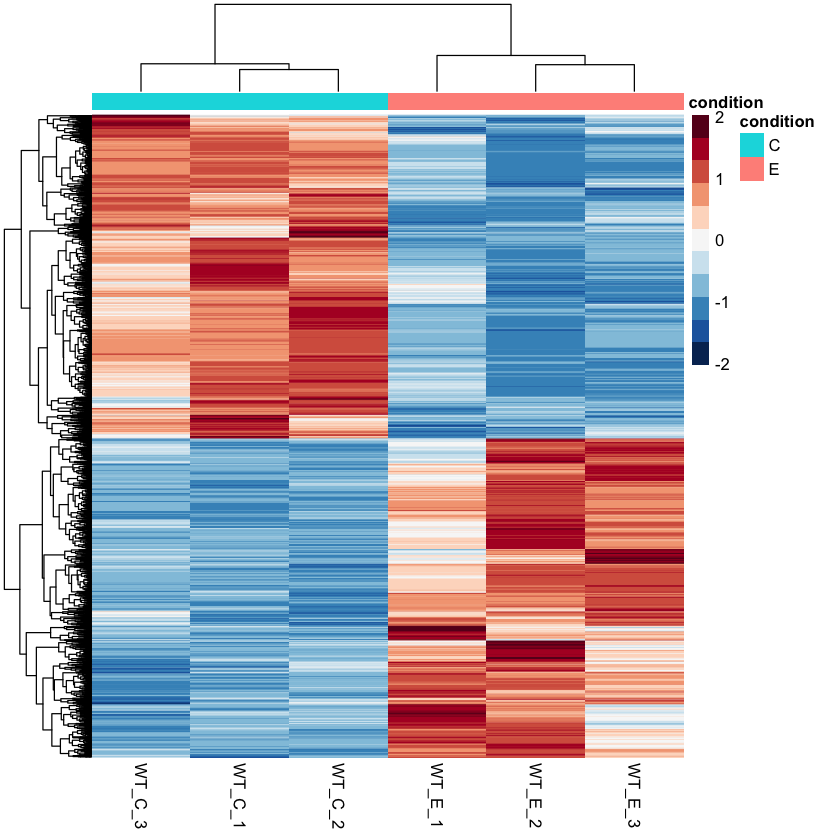

In [21]:
## Run pheatmap using the metadata data frame for the annotation
# The heatmap visualizes the expression values of these genes across samples.
# Groups genes with similar expression patterns together, improving interpretability.
pheatmap(sig_counts,
         color = heat_colors,
         cluster_rows = TRUE,
         show_rownames = FALSE,
         annotation = col_name,
         border_color = NA,
         fontsize = 10,
         scale = "row",
         fontsize_row = 10,
         height = 20)

## Volcano plot

- Filters out rows where the padj (adjusted p-value) is NA. Genes without statistical significance are excluded.
- Adds a new column, threshold, which indicates whether a gene meets the significance criteria:

In [22]:
# Volcano plot
res_table_thres <- res_tbl[!is.na(res_tbl$padj), ] |>
  mutate(threshold = padj < padj_cutoff & abs(log2FoldChange) >= log2fc_cutoff)

head(res_table_thres)
min(log10(res_table_thres$padj))

gene,baseMean,log2FoldChange,lfcSE,pvalue,padj,threshold
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
YMR174C,4392.762,5.504908,0.1840782,1.088750e-197,6.664236e-194,TRUE
YBR072W,30053.806,6.516708,0.2295216,4.279000e-178,1.309588e-174,TRUE
YBR117C,7641.370,7.430477,0.2699041,5.023902e-168,1.025043e-164,TRUE
YGR256W,7219.422,6.772904,0.2830174,1.177464e-127,1.801814e-124,TRUE
YMR175W,8530.858,7.518518,0.3353447,1.299220e-112,1.590506e-109,TRUE
YGL121C,4733.685,4.326446,0.1952246,6.559172e-110,6.691449e-107,TRUE


[1] -193.1762

In [23]:
# value counts threshold
table(res_table_thres$threshold)


FALSE  TRUE 
 3297  2824 

In [24]:
# Prepare the data dataframe
data <- res_tbl[!is.na(res_tbl$padj), ]

# Add a sig column
# Default value is "ns" (not significant).
# "Up": Genes with log2FoldChange >= 2 (upregulated) and padj < 0.05.
# "Down": Genes with log2FoldChange <= -2 (downregulated) and padj < 0.05.
data$sig <- "ns"
data$sig[data$log2FoldChange >= 2 & data$padj < 0.05] <- "Up"
data$sig[data$log2FoldChange <= -2 & data$padj < 0.05] <- "Down"

# Extract significant genes
# contains only the significant genes (both upregulated and downregulated).
sigs_df <- data[abs(data$log2FoldChange) >= 2 & data$padj < 0.05, ]
nrow(sigs_df)
head(sigs_df)

[1] 506

gene,baseMean,log2FoldChange,lfcSE,pvalue,padj,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
YMR174C,4392.762,5.504908,0.1840782,1.088750e-197,6.664236e-194,Up
YBR072W,30053.806,6.516708,0.2295216,4.279000e-178,1.309588e-174,Up
YBR117C,7641.370,7.430477,0.2699041,5.023902e-168,1.025043e-164,Up
YGR256W,7219.422,6.772904,0.2830174,1.177464e-127,1.801814e-124,Up
YMR175W,8530.858,7.518518,0.3353447,1.299220e-112,1.590506e-109,Up
YGL121C,4733.685,4.326446,0.1952246,6.559172e-110,6.691449e-107,Up


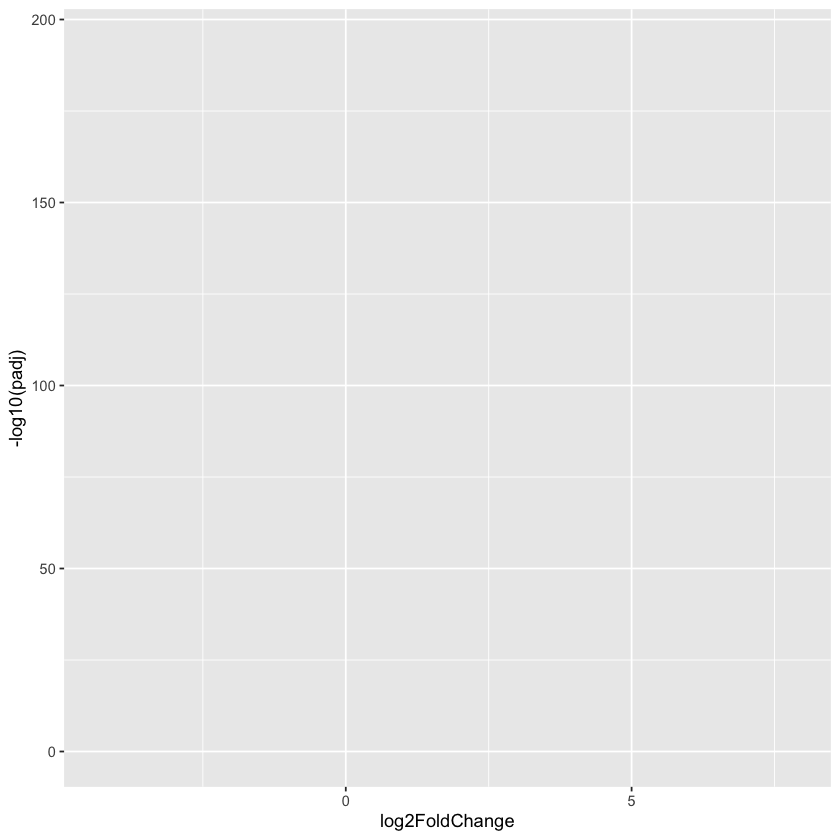

In [36]:
# Initialize the Plot
# X-axis: log2FoldChange (magnitude of gene expression change).
# Y-axis: -log10(padj) (statistical significance,
# with smaller padj values being more significant).
p_vol <- ggplot(data = data,
                aes(x = log2FoldChange,
                    y = -log10(padj)))
p_vol

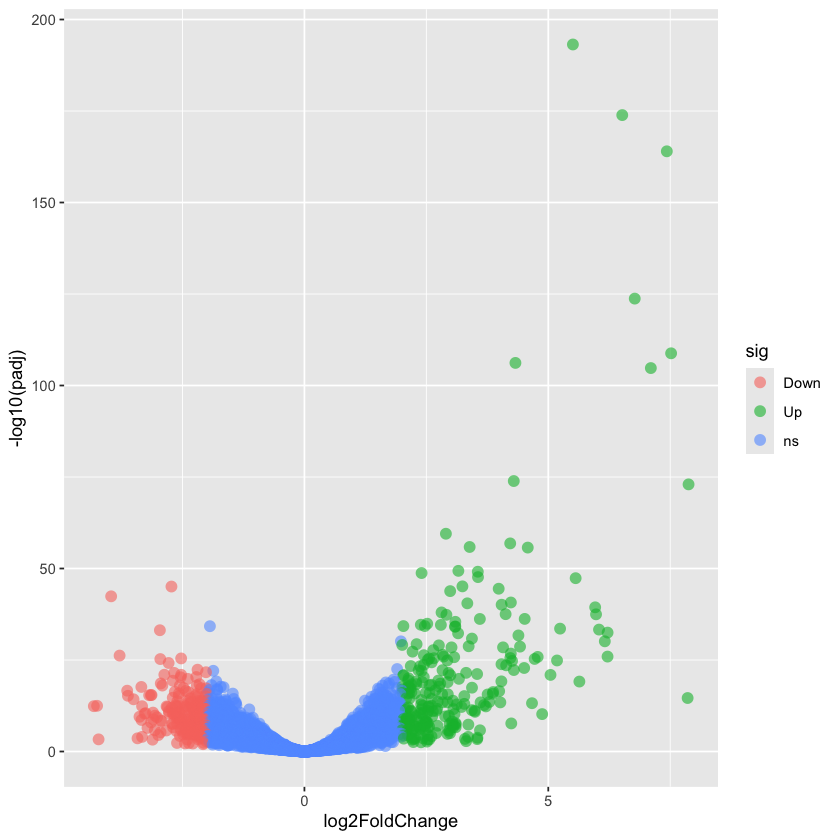

In [37]:
# Add points
p_vol <- p_vol +
  geom_point(aes(colour = sig),
             alpha = 0.6,
             shape = 16,
             size = 3)

p_vol

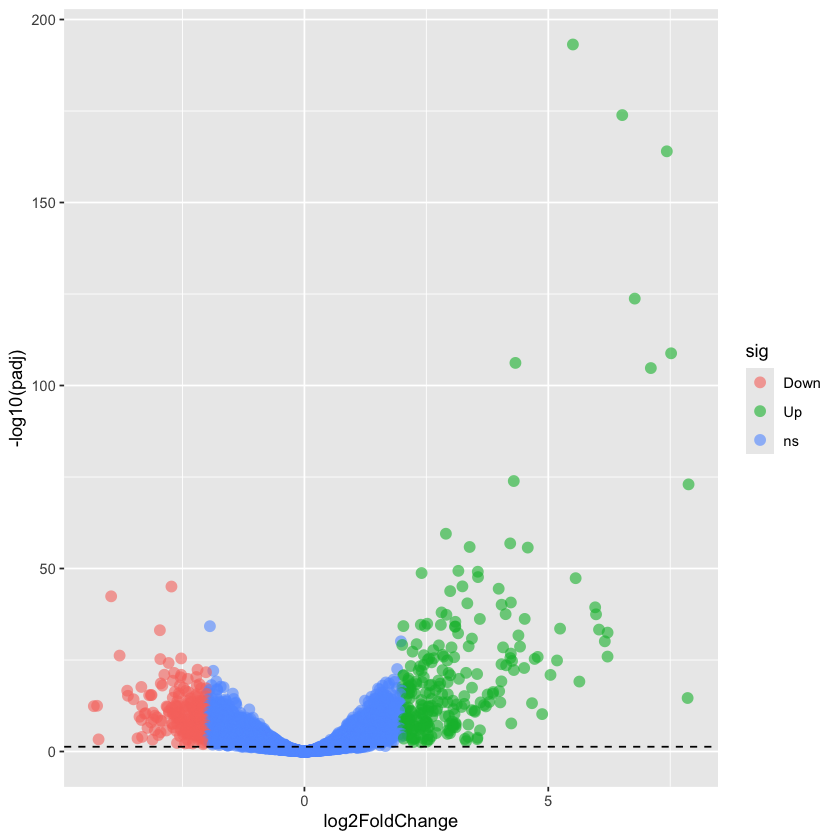

In [38]:
# Add Horizontal Line
# Indicates the statistical significance threshold (e.g., padj = 0.05).
p_vol <- p_vol +
  geom_hline(yintercept = -log10(0.05),
             linetype = "dashed")
p_vol

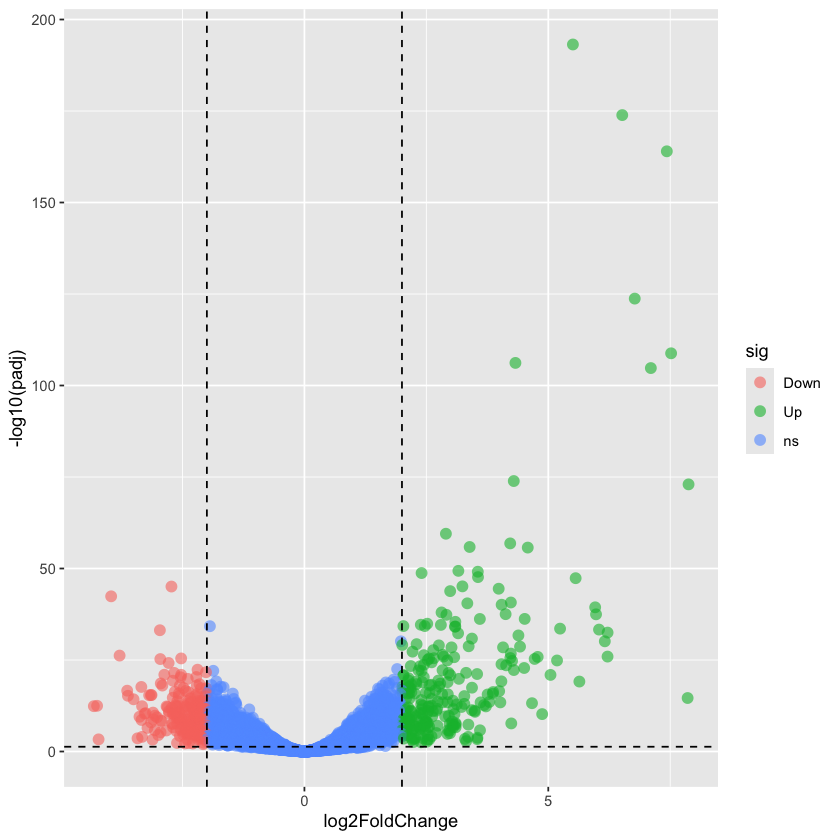

In [39]:
# Add Vertical Lines
# Marks the fold-change thresholds
# (e.g., a 4-fold change in expression corresponds to ±log2(4)).
p_vol <- p_vol +
  geom_vline(xintercept = c(-log2(4), log2(4)),
             linetype = "dashed")
p_vol

Warning message:
"ggrepel: 491 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


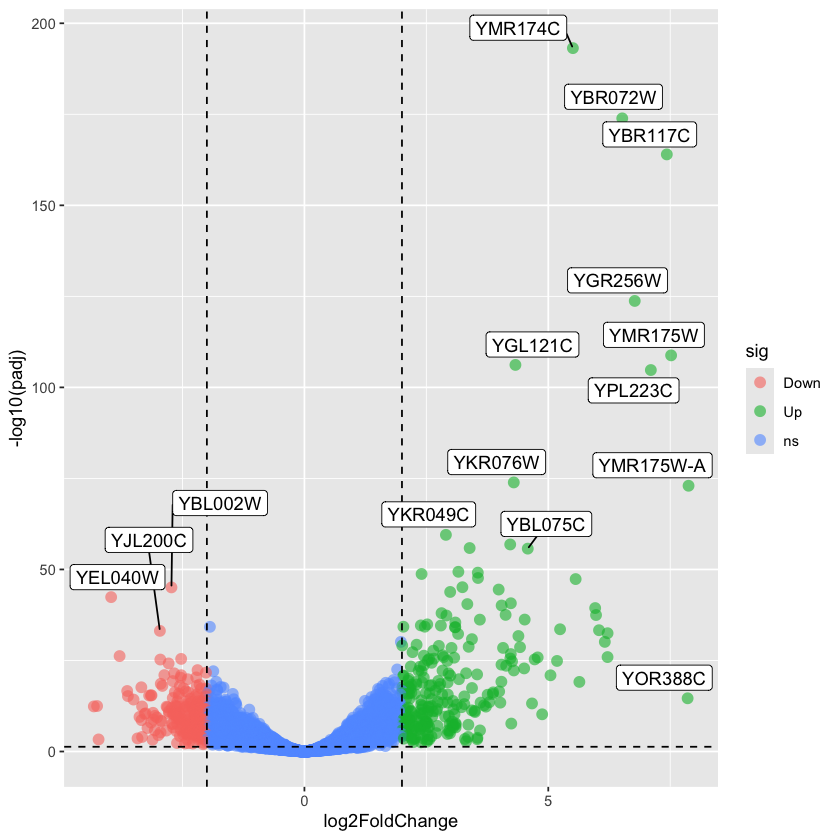

In [40]:
# Add Gene Labels
# Prevents overlapping labels by repelling them away from each other.

p_vol <- p_vol +
  geom_label_repel(data = sigs_df,
                   aes(label = gene),
                   force = 2,
                   nudge_y = 1)
p_vol

Warning message:
"Removed 19 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 19 rows containing missing values or values outside the scale range
(`geom_label_repel()`)."
Warning message:
"ggrepel: 478 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


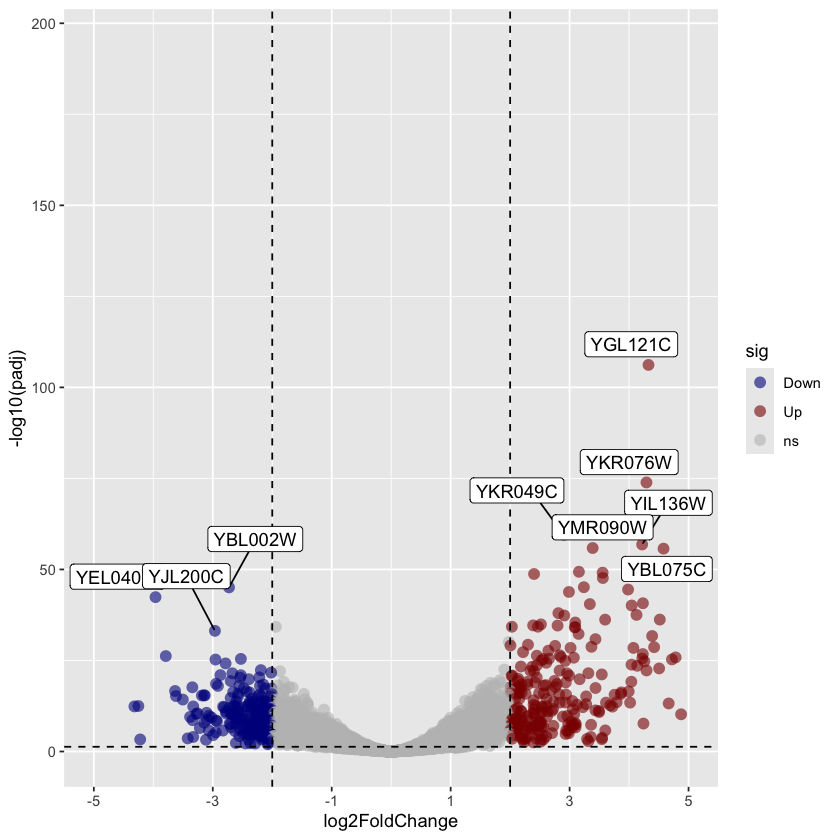

In [41]:
# Customize Colors
p_vol <- p_vol +
  scale_colour_manual(values = c("darkblue", "darkred", "grey"))

# Customize X-Axis
# Sets tick marks at intervals of 2 (e.g., -5, -3, -1, 1, 3, 5).
# Restricts the x-axis range to between -5 and 5.
p_vol <- p_vol +
  scale_x_continuous(breaks = c(seq(-5, 5, 2)),
                     limits = c(-5, 5))
p_vol

Warning message:
"Removed 19 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 19 rows containing missing values or values outside the scale range
(`geom_label_repel()`)."
Warning message:
"ggrepel: 478 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


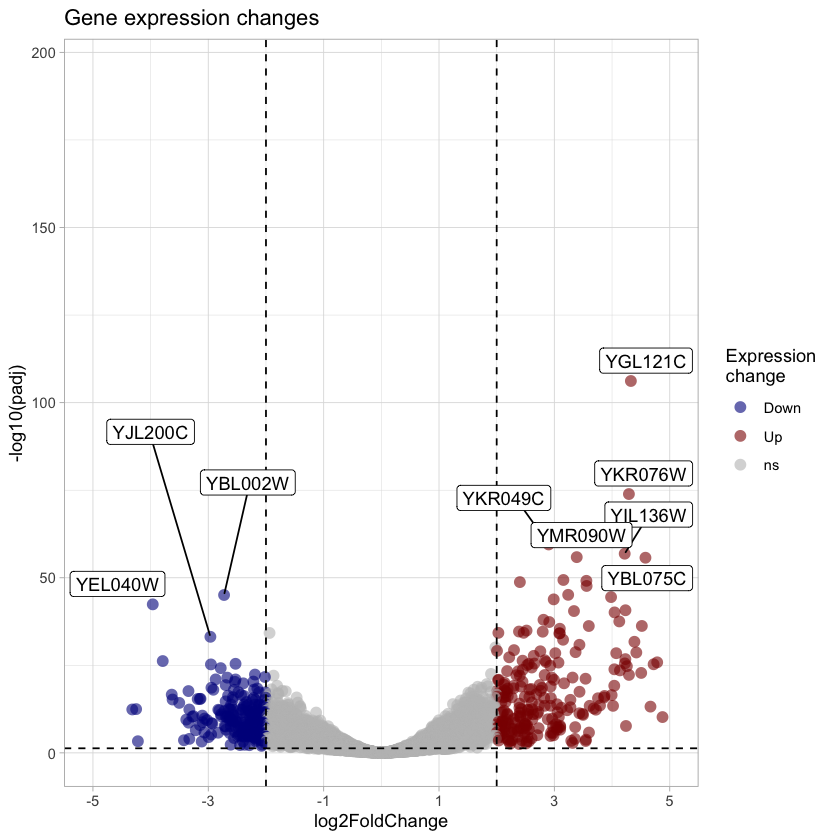

In [42]:
# Add Labels and Title
p_vol <- p_vol +
  labs(title = "Gene expression changes",
       x = "log2FoldChange",
       y = "-log10(padj)",
       colour = "Expression \nchange")

# Apply Theme
p_vol <- p_vol + theme_light()
print(p_vol)